In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import *    
import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.CNN
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
#DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [3]:
#Decide which dataset you want to predict
resp_n = 'plasma_l'
response = [col for col in DF if col.startswith(resp_n)]
response.append("patientID")
response.append("trimester")    
response_df = DF[response]
#Make sure your B trimesters are properly converted to 4

In [4]:
# Choose your responses, size, for the image and number of features we are predicting
pixels = 40
features = len(response)-2

In [5]:
#Get every combination of patient IDs in pairs of m's
# Function which returns subset or r length from n 
m = 2
IDs = response_df['patientID'].unique()
IDs = IDs.tolist()
exclude = list(combinations(IDs, m))

In [42]:
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']
predictors.remove(resp_n)

In [7]:
albums = Parallel(n_jobs=3)(delayed(butterfly.album.create_album)
                                                (DF, predictors[al], pixels) 
                                                for al in tqdm(range(6)))

100%|██████████| 6/6 [03:50<00:00, 38.35s/it]


In [8]:
#Using one omics at a time
bars_p = []
bars_o = []

for pred in tqdm(range(6)):

    prediction, observed = zip(*Parallel(n_jobs=3)
                               (delayed(butterfly.CNN.model)
                                (response_df, exclude, cv, albums[pred], pixels, features) 
                                for cv in range(len(exclude))))
                
    bars_p.append(pd.concat(prediction))
    bars_o.append(pd.concat(observed))

100%|██████████| 6/6 [33:56<00:00, 339.42s/it]


In [33]:
#Choose your correlation statistic
statistic = 'spearman'

In [34]:
#One omics at a time
results = []
for res in range(6):
    correl = bars_p[res].corrwith(bars_o[res], axis = 0, method = statistic) 
    correl[correl < 0] = 0
    results.append(np.mean(correl))

In [35]:
results

[0.14615930033242802,
 0.10653234024345029,
 0.03180111084433671,
 0.0051891380195201045,
 0.03302885574684856,
 0.019529324175812116]

In [28]:
#Using all omics at once
prediction, observed = zip(*Parallel(n_jobs=3)(delayed(butterfly.CNN.model_multi)
                                               (response_df, exclude, cv, albums, pixels, features) 
                                               for cv in tqdm(range(len(exclude)))))


100%|██████████| 136/136 [14:05<00:00,  6.22s/it]


In [36]:
#All omics at once
pred = pd.concat(prediction)
obs  = pd.concat(observed)

In [ ]:
#All omics at once
correl = pred.corrwith(obs, axis = 0, method = statistic) 
correl[correl < 0] = 0
results.append(np.mean(correl))

In [ ]:
predictors.append('all')
y_pos = np.arange(len(predictors))

In [ ]:
y_pos

In [37]:
#Create barplot 
plt.bar(y_pos, results, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 'cyan', 'salmon', 'slategray'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
plt.show()

In [43]:
predictors.append('all')
y_pos = np.arange(len(predictors))

In [44]:
y_pos

array([0, 1, 2, 3, 4, 5, 6])

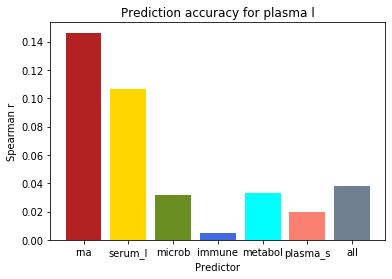

In [45]:
#Create barplot 
plt.bar(y_pos, results, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 'cyan', 'salmon', 'slategray'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
plt.show()